In [3]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import rotate
from pytomography.utils import rotate_detector_z
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Last Time

Implemented

$$H = \sum_{\theta} P(\theta) A(\theta) \otimes \hat{\theta}$$

and

$$H^T = \sum_{\theta} A^T(\theta)P^T(\theta)  \otimes \hat{\theta}^T$$

where $A(\theta)$ applies attenuation correction

* Create objects

In [4]:
dx = 0.3 #cm
x = torch.linspace(-1,1,128)
xv, yv, zv = torch.meshgrid(x,x,x, indexing='ij')
# SPECT Object
obj = (xv**2 + 0.9*zv**2 < 0.5) * (torch.abs(yv)<0.8)
obj = obj.to(torch.float).unsqueeze(dim=0)
# CT Object
mu = (xv**2 + 0.9*zv**2 < 0.3) * (torch.abs(yv)<0.6)
mu = mu.to(torch.float).unsqueeze(dim=0) * 0.1 #cm^-1

* Forward and back project

In [3]:
def rev_cumsum(x: torch.Tensor):
    return torch.cumsum(x.flip(dims=(1,)), dim=1).flip(dims=(1,)) - x/2

# Forward Projection
angles = np.arange(0,360.,3)
image = torch.zeros((1,len(angles),128,128))
for i,angle in enumerate(angles):
    mu_i = rotate_detector_z(mu, angle)
    p_i = torch.exp(-rev_cumsum(mu_i * dx))
    object_i = rotate_detector_z(obj,angle)
    image[:,i] = (object_i*p_i).sum(axis=1)
    
# Back Projection
obj_bp = torch.zeros([1, 128, 128, 128])
for i,angle in enumerate(angles):
    obj_bp_i = torch.ones([1, 128, 128, 128]) * image[:,i].unsqueeze(dim=1)
    mu_i = rotate_detector_z(mu, angle)
    p_i = torch.exp(-rev_cumsum(mu_i * dx))
    obj_bp_i = obj_bp_i * p_i
    obj_bp_i = rotate_detector_z(obj_bp_i, angle, negative=True)
    obj_bp += obj_bp_i

# This Time

Now we need to add PSF blurring to $H$

<img src="../images/psf.png" alt= “” width="600">

The red distributions to the right represent probability distributions of where the emission is detected on the detector. The closer the emission is to the detector, the narrower the response function.

* For many realistic cases, the curve is Gaussian, and the relationship between $\sigma$ and the distance to the detector $z$ follows a linear relationship:

$$\sigma(r) = ar+b$$

So how do we simulate this in $H$?

1. Use different blurring kernels for each location, dependent on location from the detector with width given by $\sigma=ar+b$
2. Forward project

<img src="../images/psf2.png" alt= “” width="600">

For this we'll need a few functions:

* Get radial distances from projection to scanner, given $R$ (detector radius) and $dx$ (spacing).

In [5]:
def get_distance(Lx: int, R: float, dx: float):
    if Lx%2==0:
        r = R + (Lx/2 - np.arange(Lx) - 1/2) * dx
    else:
        r = R + ((Lx-1)/2 - np.arange(Lx) ) * dx
    # Correction for if radius of scanner is inside the the bounds
    r[r<0] = 0
    return r

* This function uses `get_distance` to get $\sigma$ at each point in the array. `collimator_slope` is $a$, and `collimator_intercept` is $b$

In [6]:
def get_sigma(
        radius: float,
        dx: float,
        Lx: tuple,
        collimator_slope: float,
        collimator_intercept: float
    ) -> np.array:
        distances = get_distance(Lx, radius, dx)
        sigma = collimator_slope * distances + collimator_intercept
        return sigma

In [7]:
sigma = get_sigma(radius=25, dx=0.3, Lx=128, collimator_slope=0.07, collimator_intercept=0.1)
sigma

array([3.1835, 3.1625, 3.1415, 3.1205, 3.0995, 3.0785, 3.0575, 3.0365,
       3.0155, 2.9945, 2.9735, 2.9525, 2.9315, 2.9105, 2.8895, 2.8685,
       2.8475, 2.8265, 2.8055, 2.7845, 2.7635, 2.7425, 2.7215, 2.7005,
       2.6795, 2.6585, 2.6375, 2.6165, 2.5955, 2.5745, 2.5535, 2.5325,
       2.5115, 2.4905, 2.4695, 2.4485, 2.4275, 2.4065, 2.3855, 2.3645,
       2.3435, 2.3225, 2.3015, 2.2805, 2.2595, 2.2385, 2.2175, 2.1965,
       2.1755, 2.1545, 2.1335, 2.1125, 2.0915, 2.0705, 2.0495, 2.0285,
       2.0075, 1.9865, 1.9655, 1.9445, 1.9235, 1.9025, 1.8815, 1.8605,
       1.8395, 1.8185, 1.7975, 1.7765, 1.7555, 1.7345, 1.7135, 1.6925,
       1.6715, 1.6505, 1.6295, 1.6085, 1.5875, 1.5665, 1.5455, 1.5245,
       1.5035, 1.4825, 1.4615, 1.4405, 1.4195, 1.3985, 1.3775, 1.3565,
       1.3355, 1.3145, 1.2935, 1.2725, 1.2515, 1.2305, 1.2095, 1.1885,
       1.1675, 1.1465, 1.1255, 1.1045, 1.0835, 1.0625, 1.0415, 1.0205,
       0.9995, 0.9785, 0.9575, 0.9365, 0.9155, 0.8945, 0.8735, 0.8525,
      

Remember the object shape is (1,128,128,128) and we want to blur the first axis. We can build a convolutional neural network to apply a seperate Gaussian blurring kernel for each slice on axis 1.

In [10]:
N = len(sigma)
kernel_size = 17
delta = 1e-9
layer = torch.nn.Conv2d(N, N, kernel_size, groups=N, padding='same',
                        padding_mode='zeros', bias=0)
x_grid, y_grid = torch.meshgrid(2*[torch.arange(-int(kernel_size//2), int(kernel_size//2)+1)], indexing='ij')
x_grid = x_grid.unsqueeze(dim=0).repeat((N,1,1))
y_grid = y_grid.unsqueeze(dim=0).repeat((N,1,1))
sigma = torch.tensor(sigma, dtype=torch.float32).reshape((N,1,1))
kernel = torch.exp(-(x_grid**2 + y_grid**2) / (2*sigma**2 + delta))
kernel = kernel / kernel.sum(axis=(1,2)).reshape(N,1,1)
layer.weight.data = kernel.unsqueeze(dim=1)

Note that the blurring is independent of the detector angle (unless the detector follows a non-circular path, and in the source code, we adjust the code to allow for this generality)

In [11]:
# Forward Projection
angles = np.arange(0,360.,3)
image = torch.zeros((1,len(angles),128,128))
for i,angle in enumerate(angles):
    object_i = layer(rotate_detector_z(obj,angle))
    image[:,i] = object_i.sum(axis=1)
image = image.detach() #because was passed through network

Lets look at some resulting images

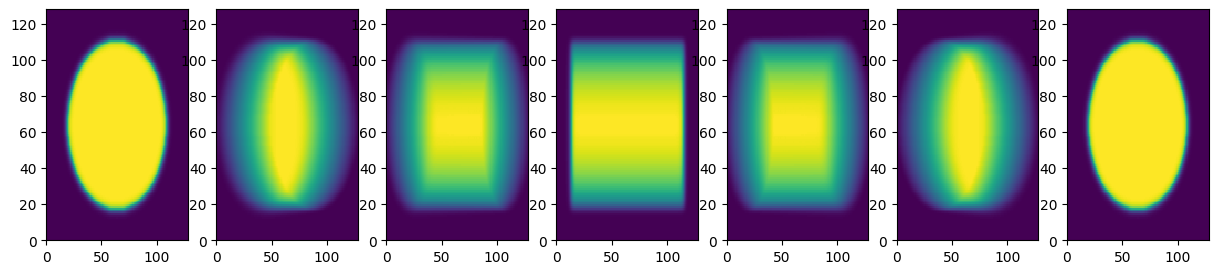

In [12]:
iis = [0,10,20,30,40,50,60]
fig, ax = plt.subplots(1,7,figsize=(15,3))
[a.pcolormesh(image[0,i].T) for (a, i) in zip(ax, iis)]
plt.show()

In [13]:
obj_bp = torch.zeros([1, 128, 128, 128])
for i,angle in enumerate(angles):
    obj_bp_i = torch.ones([1, 128, 128, 128]) * image[:,i].unsqueeze(dim=1)
    obj_bp_i = layer(obj_bp_i)
    obj_bp_i = rotate_detector_z(obj_bp_i, angle, negative=True)
    obj_bp += obj_bp_i